In [441]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import myutils
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from IPython.display import display

In [311]:
SIZE = (28, 28)

Original dataset consists of two folders, each with 15,000 images. I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. They are stored in `negative-samples` and `positive-samples`

Data obtained from https://www.kaggle.com/datasets/oluwaseunad/concrete-and-pavement-crack-images/code

In [312]:
d1, d2 = 'data/negative-samples', 'data/positive-samples'
negative_images, positive_images = [], []

filenames1 = os.listdir(d1)
for filename in filenames1:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d1, filename))
            
            # resize image to 128x128 pixels
            img = ImageOps.fit(img, SIZE, method=Image.LANCZOS)
            # grayscale image
            img = ImageOps.grayscale(img)
            
            negative_images.append(img)

filenames2 = os.listdir(d2)
for filename in filenames2:
    
    if filename.endswith(".jpg"):
            
            img = Image.open(os.path.join(d2, filename))
            img = ImageOps.fit(img, SIZE, method=Image.LANCZOS)
            img = ImageOps.grayscale(img)
            
            positive_images.append(img)

In [313]:
print(len(negative_images))
print(len(positive_images))

1000
1000


In [361]:
# shuffle the images
random.shuffle(negative_images)
random.shuffle(positive_images)

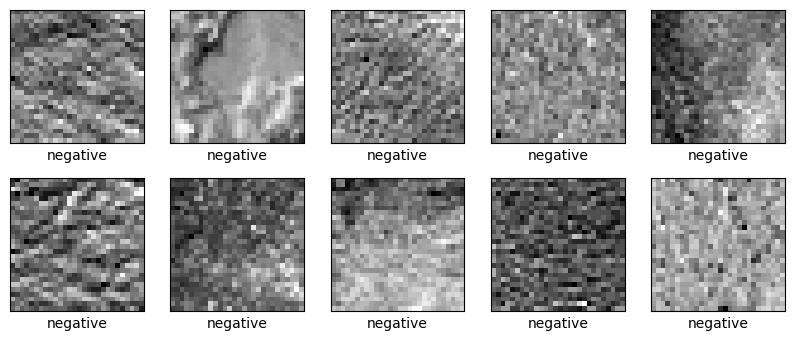

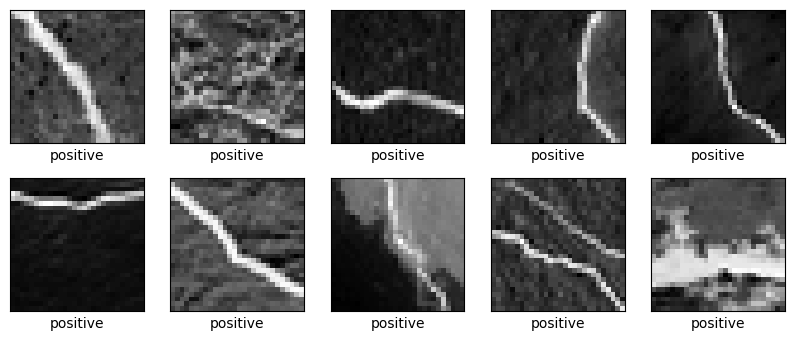

In [362]:
# display first 10 negative images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(negative_images[i], cmap=plt.cm.binary)
    plt.xlabel("negative")
plt.show()
# display first 10 positive images
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(positive_images[i], cmap=plt.cm.binary)
    plt.xlabel("positive")
plt.show()

Now we turn these images into numpy arrays.

In [370]:
X_n = np.stack([np.array(img) for img in negative_images])
X_p = np.stack([np.array(img2) for img2 in positive_images])
X = np.vstack((X_n, X_p))
print("Shape of X:", X.shape)

# store data into array, where each element is [(0 or 1), (2d array of image)]
df = []
for i in range(2000):
    # first 1000 images are negative, and remaining 1000 images are positive
    if i < 1000:
        df.append([0, X[i]])
    else:
        df.append([1, X[i]])

# shuffle
np.random.shuffle(df)
print("Lenght of df:", len(df))
print("First element in df:\n", df[0])

Shape of X: (2000, 28, 28)
Lenght of df: 2000
First element in df:
 [1, array([[63, 68, 80, 84, 73, 66, 74, 36,  7, 57, 61, 59, 55, 61, 61, 64,
        60, 73, 62, 57, 64, 72, 78, 55, 69, 69, 61, 65],
       [69, 76, 72, 71, 69, 66, 70, 58,  7, 44, 65, 57, 57, 62, 66, 64,
        53, 70, 59, 69, 57, 66, 61, 67, 70, 65, 60, 68],
       [61, 69, 66, 71, 64, 66, 66, 66, 23, 32, 69, 61, 59, 66, 71, 60,
        55, 59, 62, 64, 61, 63, 71, 67, 58, 65, 66, 66],
       [74, 72, 75, 86, 69, 61, 64, 56, 47, 15, 47, 68, 62, 60, 55, 62,
        60, 51, 58, 57, 60, 66, 64, 59, 62, 72, 63, 64],
       [56, 74, 86, 82, 65, 66, 65, 61, 49,  7,  8, 48, 70, 61, 60, 67,
        64, 56, 59, 61, 57, 69, 68, 60, 65, 61, 62, 66],
       [78, 65, 70, 68, 70, 72, 66, 71, 61, 34, 10, 12, 44, 62, 71, 69,
        60, 55, 62, 65, 60, 63, 74, 63, 62, 62, 63, 60],
       [86, 70, 63, 70, 70, 70, 71, 67, 62, 42, 41, 46,  7, 39, 75, 57,
        57, 63, 57, 61, 57, 55, 65, 62, 65, 62, 60, 60],
       [69, 66, 61, 53, 7

X[0] shape: (28, 28)
y[0] = 1.0


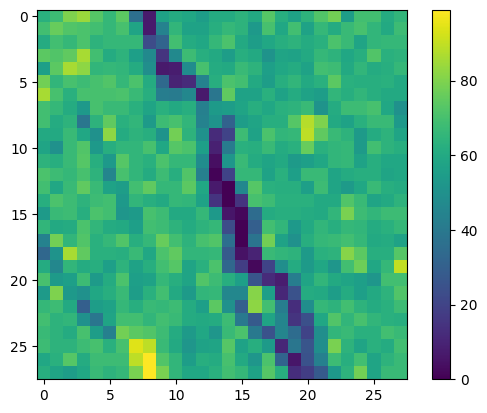

In [371]:
# separate df into X and y

X = np.zeros((2000, SIZE[0], SIZE[1]))
y = np.zeros((2000,))

for i in range(2000):
    y[i] = df[i][0]
    X[i] = df[i][1]

# take a look at sample 1
print("X[0] shape:", X[0].shape)
print("y[0] =", y[0])
plt.imshow(X[0])
plt.colorbar()

Scale the pixel values before training

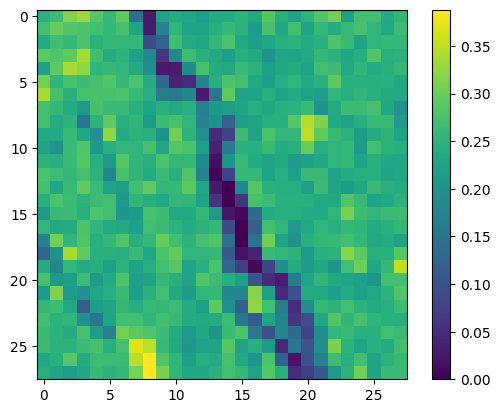

In [372]:
# scale pixel values
X = X / 255.0

plt.imshow(X[0])
plt.colorbar()

Split training data 60-20-20 (train, cv, test)

In [373]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 28, 28)
y train: (1200,)
X cv: (400, 28, 28)
y cv: (400,)
X test: (400, 28, 28)
y test: (400,)


In [435]:
# create model

tf.random.set_seed(42)
input_shape = (SIZE[0], SIZE[1], 1)

model = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
        
    ], name = "mymodel"
)

In [436]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_cv, y_cv))

Epoch 1/10
38/38 [==============================] - 1s 16ms/step - loss: 0.6907 - accuracy: 0.5050 - val_loss: 0.6865 - val_accuracy: 0.4600
Epoch 2/10
38/38 [==============================] - 0s 11ms/step - loss: 0.6268 - accuracy: 0.6442 - val_loss: 0.5404 - val_accuracy: 0.7725
Epoch 3/10
38/38 [==============================] - 0s 11ms/step - loss: 0.4824 - accuracy: 0.7825 - val_loss: 0.4523 - val_accuracy: 0.8075
Epoch 4/10
38/38 [==============================] - 1s 15ms/step - loss: 0.4276 - accuracy: 0.8233 - val_loss: 0.4304 - val_accuracy: 0.8250
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 0.3916 - accuracy: 0.8325 - val_loss: 0.4153 - val_accuracy: 0.8275
Epoch 6/10
38/38 [==============================] - 0s 11ms/step - loss: 0.3739 - accuracy: 0.8442 - val_loss: 0.3998 - val_accuracy: 0.8375
Epoch 7/10
38/38 [==============================] - 0s 11ms/step - loss: 0.3706 - accuracy: 0.8475 - val_loss: 0.3944 - val_accuracy: 0.8475
Epoch 8/10
38

Evaluate model

Evaluation with cross-validation dataset:

model 1:
	loss = 0.324270099401474
	accuracy = 0.875


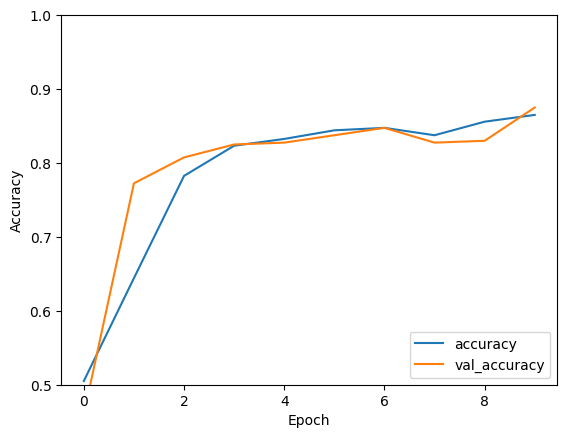

In [437]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
print(f"model 1:\n\tloss = {cv_loss}\n\taccuracy = {cv_acc}")

Tune hyperparameters

The model has an overfitting problem since `accuracy` > `val_accuracy`. Lets try out different learning rates.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Learning rate = 0.1
	loss = 0.6990688443183899
	accuracy = 0.46000000834465027
Learning rate = 0.01
	loss = 0.3312724828720093
	accuracy = 0.8700000047683716
Learning rate = 0.001
	loss = 0.324270099401474
	accuracy = 0.875
Learning rate = 0.0001
	loss = 0.4807046949863434
	accuracy = 0.7975000143051147


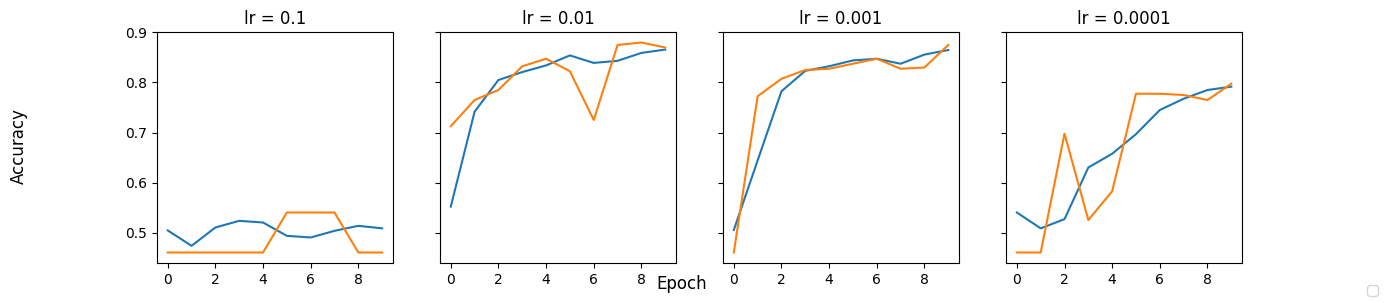

In [449]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
fig, axes = plt.subplots(ncols=len(learning_rates), figsize=(14,3), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')
fig.legend(loc='lower right')

for i, lr in enumerate(learning_rates):
    # reset the model
    model = myutils.create_model(SIZE)
    
    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    history = model.fit(X_train, y_train, epochs=10, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    axes[i].set_title(f"lr = {lr}")
    axes[i].plot(history.history['accuracy'], label='accuracy')
    axes[i].plot(history.history['val_accuracy'], label = 'val_accuracy')

    cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")
    

Ways to improve model:

- ! add/remove layers, increase/decrease neurons
- ! regularization like L1 or L2
- increase/decrease training data
- ! tuning hyperparameters like learning rate or batch size
- ! add dropout layers
- change image resolution?